<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/master/notebooks/covid-19-active.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project: Estimating current Covid-19 infections (including undiagnosed) from multiple sources

# Background

This notebook allows forecasting different COVID-19 related parameters, by using probability distributions, and integrating spreadsheets and the forecasting platform Foretold.io.

## Using the Colab
- Run the colab by going to Runtime > "Run All"
- You'll need to follow the instructions in the output of the "Authentication" section to allow the colab to read google sheets 
- If you want to use private foretold predictions, set foretold_token to the token of a bot account on foretold with access to the private channel
- You can override parameters for individual regions with point estimates in the [Parameter Spreadsheet](https://docs.google.com/spreadsheets/d/1n42Op7sE3vUs4v2oSO19OM7yBH-9LIjPOp2dK_DtsMM/edit?usp=sharing)
- The priority order for parameters is: 1. foretold distributions from the parameters table [https://www.foretold.io/c/1dd5b83a-075c-4c9f-b896-3172ec899f26/n/245566be-1e01-4dbf-9dcd-f0754b44e99e] 2. point estimates from the parameters google sheet 3. foretold distribution for the parameter for the world from the parameters table
- The colab notebook will output active_infections_prediction.csv (active infections) and countermeasures.csv (countermeasures). If using Google Chrome they should download automatically, otherwise you can open the File pane on the left side of the screen and right click on the file to download
- If you want to make changes, it's probably best to make your own copy of the colab

## Notes
- Currently, doesn't predict for regions with < 1000 cases or < 10 deaths. If you want to remove this restriction, comment out the cell after "Restrict to countries with > 1000 cases and > 10 deaths"

- Does not yet directly support overriding parameters with a different foretold distribution
- Does not yet directly support overriding history of the number of cases

If you need to override any of these values for a specific region, you can likely load the data and modify the function that retrieves that parameter in the "Data Retrieval Functions" cell to substitute in your data


# Authentication

In [1]:
!pip install --progress-bar off --quiet typing_extensions
!pip install --progress-bar off --quiet poetry  # Fixes https://github.com/python-poetry/poetry/issues/532
!pip install --progress-bar off --quiet git+https://github.com/oughtinc/ergo.git@5614ff88bd13dbc7946be1e559e67ad633ffa76c
!pip install --progress-bar off --quiet pendulum seaborn
import ergo







  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done







ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.1 which is incompatible.
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import google
#Authenticate (needs user interaction, so don't hide this cell)
google.colab.auth.authenticate_user()

foretold_token = "YOUR-TOKEN"

# Setup

## General

In [3]:
!pip install -q pendulum pycountry

     |████████████████████████████████| 10.0MB 2.3MB/s 


In [0]:
%load_ext google.colab.data_table

In [0]:
import pandas as pd
import pendulum
import gspread
import numpy as np
import math
import pycountry
import datetime
import tqdm
import time
import seaborn
import torch

from matplotlib import pyplot as plt
from io import StringIO
from types import SimpleNamespace

from oauth2client.client import GoogleCredentials

## Ergo

## Epimodel

In [6]:
!git clone -q https://github.com/epidemics/epimodel
%cd /content/epimodel
!git pull
!git clone -q https://github.com/epidemics/epimodel-covid-data data
%cd /content/epimodel/data
!git pull
%cd /content
import sys
sys.path.append('epimodel')

/content/epimodel
Already up to date.
/content/epimodel/data
Already up to date.
/content


Epimodel needs unidecode:

In [7]:
!pip install -q unidecode

     |████████████████████████████████| 245kB 2.6MB/s 


In [0]:
import epimodel
regions = epimodel.RegionDataset.load('epimodel/data/regions.csv')

In [0]:
def name_to_code(name):
  try:
      return regions.find_one_by_name(name).Code
  except KeyError:
      return ""

## Loading Data

## Utility Functions

In [0]:
from uuid import UUID
def is_uuid(s):
  try:
    uuid_obj = UUID(s, version=4)
    return True
  except ValueError:
    return False

def load_spreadsheet(url, sheet):
    gc = gspread.authorize(GoogleCredentials.get_application_default())
    wb = gc.open_by_url(url)
    sheet = wb.worksheet(sheet)
    values = sheet.get_all_values()
    return values

# Estimating active infections

In order to get an estimate of active infections, four different models are ensembled.

The first three models are statistical and source their parameters from [this Foretold community](https://www.foretold.io/c/1dd5b83a-075c-4c9f-b896-3172ec899f26/notebooks), if available, and otherwise as point estimates from [this spreadsheet](https://docs.google.com/spreadsheets/d/1n42Op7sE3vUs4v2oSO19OM7yBH-9LIjPOp2dK_DtsMM/edit?usp=sharing). 

The fourth model is simply a human-estimated distribution of active infections.

The models are described in more detail [here](https://www.notion.so/Ensemble-model-for-estimating-active-infections-00b72ecf6f674602ad27efb15249dd7e).

## Load Parameters from [Parameter Spreadsheet](https://docs.google.com/spreadsheets/d/1n42Op7sE3vUs4v2oSO19OM7yBH-9LIjPOp2dK_DtsMM/edit?usp=sharing)

In [0]:
def get_code(row):
  if row["Province/State"]:
    return name_to_code(row["Province/State"])
  return name_to_code(row["Country/Region"])

def load_parameters(parameters_url, parameters_sheet):
    values = load_spreadsheet(parameters_url, parameters_sheet)
    d = {}
    columns = values[0]
    for row in values[1:]:
      if row[0]:
        code = name_to_code(row[0])
      else:
        code = name_to_code(row[1])
      d[code] = {column: value for column, value in zip(columns, row)}
    return d

parameters = load_parameters('https://docs.google.com/spreadsheets/d/1n42Op7sE3vUs4v2oSO19OM7yBH-9LIjPOp2dK_DtsMM/edit', 'Parameters')

## Load Foretold Parameters

### Foretold Parameter JSON

In [0]:
# Need to replace with full json created by Ozzie
foretold_lookup = [
    {
        "name": "@locations/n-hungary",
        "locationData": {
            "name": "Hungary",
            "isoCode": "HU",
            "foretoldName": "@locations/n-hungary"
        },
        "april19": "fceee746-01f9-42b5-9bb4-f5141196c163",
        "april26": "126f6846-90b4-4e44-bc71-cf4918367344",
        "may3": "1fdc46e2-c641-45f7-99cf-58469f2d5606",
        "may17": "033e3efd-17d7-498a-bc63-28de2cdf225b",
        "deathsAttributed": "2dee3f58-c6cd-4503-85f6-3e886f72fb50",
        "infectionsAttributed": "0d4f247b-2d25-4289-a3ff-411e44067abf",
        "timeToDeath": "9109a7d8-9eab-4094-93ea-15c92348033e",
        "infectionFatalityRatio": "0d7bea59-100a-4945-9fcd-f5351e89950b"
    },
    {
        "name": "@locations/n-czech-republic",
        "locationData": {
            "name": "Czech Republic",
            "isoCode": "CZ",
            "foretoldName": "@locations/n-czech-republic"
        },
        "april19": "c08c0ea4-09fe-45fe-9caf-9697a67f3262",
        "april26": "46fbf258-70a9-4c39-9f3b-5d6f91930632",
        "may3": "d892166d-d14c-4edf-8475-4b1b274c3656",
        "may17": "fcab14bf-50e0-4c61-a9fa-cdf1835af007",
        "deathsAttributed": "901e86f9-4841-4f9f-b555-d61417d1fb7a",
        "infectionsAttributed": "2493fa7f-75f3-4396-bef5-5ae6b4bae324",
        "timeToDeath": "7a0b3b4b-2a5c-4a0f-b500-c950d65fc028",
        "infectionFatalityRatio": "d465c517-dce7-4d92-b173-26e022e74610"
    },
    {
        "name": "@locations/n-ukraine",
        "locationData": {
            "name": "Ukraine",
            "isoCode": "UA",
            "foretoldName": "@locations/n-ukraine"
        },
        "april19": "a176eb57-39d6-4a9c-97be-58ab9eb9f55a",
        "april26": "94750cd8-dcaf-4fad-a483-e46cfbba12e3",
        "may3": "465af1bd-90f0-4c0e-bb2a-eec1047aa247",
        "may17": "bcba6198-093c-4534-b17a-5815386ac64f",
        "deathsAttributed": "d32ad94f-e8c4-4337-9a25-31e91bcfa63d",
        "infectionsAttributed": "3b21bbf2-0287-4624-b409-4832f8055b0d",
        "timeToDeath": "678bbd80-2864-4cd0-a63d-3ad027600e8b",
        "infectionFatalityRatio": "34950965-c488-4b11-8956-c10a20e3d0e6"
    },
    {
        "name": "@locations/n-netherlands",
        "locationData": {
            "name": "Netherlands",
            "isoCode": "NL",
            "foretoldName": "@locations/n-netherlands"
        },
        "april19": "562c5477-5037-45e1-b626-2b0dc33d92f9",
        "april26": "b334bfcf-a3ef-49fa-9c4c-26aacd8ff337",
        "may3": "c2f72783-a3fc-43d8-b92d-0d2abf52217c",
        "may17": "87ae4c8d-5fdf-4961-9087-8639afa12124",
        "deathsAttributed": "486f78ed-4c13-4adb-b399-95f9556c5fe3",
        "infectionsAttributed": "0902bcff-0253-4eec-9864-d5643057fbae",
        "timeToDeath": "7e4e9c8e-307f-4216-8463-9bb5f3fd08a4",
        "infectionFatalityRatio": "06e42fc2-eb27-4897-818d-5e954964399c"
    },
    {
        "name": "@locations/n-united-kingdon",
        "locationData": {
            "name": "United Kingdon",
            "isoCode": "GB",
            "foretoldName": "@locations/n-united-kingdon"
        },
        "april19": "42476b18-e386-4c35-9f4b-a8f1cda264a9",
        "april26": "7615f40d-f086-49b9-b5b5-f33d0e13a705",
        "may3": "2a4336ac-a340-477a-9611-9d8578389304",
        "may17": "d1778b1b-d956-414d-8aeb-82d6c3c08110",
        "deathsAttributed": "315d095d-ae05-4e9d-80e3-1fb27246f7c2",
        "infectionsAttributed": "76261599-422b-463c-ad4d-92962bc6c368",
        "timeToDeath": "b88df3fd-8af7-46bf-8144-252703281580",
        "infectionFatalityRatio": "70ed6dfb-0e84-462e-a06b-a985800be2d3"
    },
    {
        "name": "@locations/n-russia",
        "locationData": {
            "name": "Russia",
            "isoCode": "RU",
            "foretoldName": "@locations/n-russia"
        },
        "april19": "9cf07291-7d43-4899-b391-bbf6977b5fee",
        "april26": "7442037d-e749-4a1b-97a9-716f12363c70",
        "may3": "3e919b5d-a049-4090-99b8-0f411f7366d5",
        "may17": "a436113f-aa22-449b-951e-9f577d26fbb9",
        "deathsAttributed": "57bf9b8b-40ea-43d2-9085-70d12500197d",
        "infectionsAttributed": "cdc51237-62ca-4157-9d3f-f1c963add9aa",
        "timeToDeath": "a4f58a70-ef24-493a-a835-a1051f23f3fd",
        "infectionFatalityRatio": "0f5e66eb-e615-4fcc-a0b9-f9182bb2c03b"
    },
    {
        "name": "@locations/n-france",
        "locationData": {
            "name": "France",
            "isoCode": "FR",
            "foretoldName": "@locations/n-france"
        },
        "april19": "70407aee-ffcf-4466-b352-6b05dc424c10",
        "april26": "bd443efd-12f5-4db4-83d4-d65567797c91",
        "may3": "4bb96a2d-6103-40af-be6f-2e33f48a4298",
        "may17": "44cce87c-649a-4414-ab97-ff24a5fb5167",
        "deathsAttributed": "bb4c4a26-4882-4a12-a449-6df4fc1d4b75",
        "infectionsAttributed": "855bece8-0364-487d-adf2-0e253fb30475",
        "timeToDeath": "dc649a48-f8b1-47cd-ba36-6190e8934108",
        "infectionFatalityRatio": "5f8c61ac-00b4-4438-bc12-a4c4444a9676"
    },
    {
        "name": "@locations/n-belarus",
        "locationData": {
            "name": "Belarus",
            "isoCode": "BY",
            "foretoldName": "@locations/n-belarus"
        },
        "april19": "98889cef-85b2-4672-80d4-c6eee321e0c4",
        "april26": "e778ebe3-b7c4-4b2b-b210-2015967ef772",
        "may3": "b568f648-4542-4487-a540-f91cb571fa22",
        "may17": "eaa948ec-be88-4efd-a04f-c5cba0894a0a",
        "deathsAttributed": "60c88d73-d8fd-42ca-8259-cafa032fb21d",
        "infectionsAttributed": "a294bf30-f589-4b2a-a28b-c50942c26163",
        "timeToDeath": "1d90b66b-2c43-42a3-8e2d-b221973a90c8",
        "infectionFatalityRatio": "1f9e4a9f-5099-4f74-984e-6f184b0467e5"
    },
    {
        "name": "@locations/n-spain",
        "locationData": {
            "name": "Spain",
            "isoCode": "ES",
            "foretoldName": "@locations/n-spain"
        },
        "april19": "1e17b500-92fe-4ef5-a36c-77182fc5f712",
        "april26": "5477c30e-8303-4c5c-93f0-27317226e56f",
        "may3": "70a5c96f-1571-4b83-90a3-cc775dd72f6f",
        "may17": "0dd70995-b4f0-472a-9095-fbc71d5255ff",
        "deathsAttributed": "eff08726-220c-4da5-94fc-a3ba26c44421",
        "infectionsAttributed": "230ba580-9681-4379-9fe5-3639d73adcce",
        "timeToDeath": "8deae807-bdd3-43c0-a8a4-6eb98c358e83",
        "infectionFatalityRatio": "3103be98-d7d5-4335-b279-fde5fe5f670b"
    },
    {
        "name": "@locations/n-italy",
        "locationData": {
            "name": "Italy",
            "isoCode": "IT",
            "foretoldName": "@locations/n-italy"
        },
        "april19": "b6e8caf6-afec-428a-adf3-44b962d99383",
        "april26": "7422ee75-a130-4b24-b025-d349df24100e",
        "may3": "90e76d42-2685-47ff-b8fe-fb80be829333",
        "may17": "a1770f21-55a6-415b-8da2-f71411d1f0ae",
        "deathsAttributed": "150b74e0-a92b-41d8-8020-0078bdb5c836",
        "infectionsAttributed": "4a3dec41-0688-4605-85ac-cae427e9ca51",
        "timeToDeath": "af23f463-4231-493a-897e-9d8b903cac90",
        "infectionFatalityRatio": "f2456630-cef3-42dd-8fef-d6e6a95e5d2c"
    },
    {
        "name": "@locations/n-nepal",
        "locationData": {
            "name": "Nepal",
            "foretoldName": "@locations/n-nepal"
        },
        "april19": "c049c851-a806-4eb7-be7c-fbe988e88121",
        "april26": "a9447b87-fd25-49b5-81f1-f89880bc196d",
        "may3": "3845ef90-ccb1-418f-a6f3-ee5131fdf167",
        "may17": "0b9c19cb-945d-4523-95b1-97d5b578318b",
        "deathsAttributed": "a9335e1d-2e85-4bfd-b8b0-4d6915604997",
        "infectionsAttributed": "c11e38a3-02ef-4998-99ff-500621f60e5c",
        "timeToDeath": "b5eb2dc1-e1d3-4e92-97c5-79d45299f827",
        "infectionFatalityRatio": "908ceff9-c8d7-4a07-8984-1f43bde37459"
    },
    {
        "name": "@locations/n-india",
        "locationData": {
            "name": "India",
            "isoCode": "IN",
            "foretoldName": "@locations/n-india"
        },
        "april19": "d5115540-209e-4e3f-9a38-76e45b60574a",
        "april26": "c5b8f0f2-b4fa-4bf3-a375-6d0e8cd0bbb0",
        "may3": "a3808a82-6424-40c7-bf2e-7459540656b9",
        "may17": "a011d2a3-3bc2-4045-9b43-a4381325d5f7",
        "deathsAttributed": "0b47a481-72d5-486f-84cb-a2f3ab20c6d0",
        "infectionsAttributed": "deecf45a-03c5-457e-ba8e-ed51b63eab01",
        "timeToDeath": "c1bfe7db-0bfc-4265-ab5e-388ddf349336",
        "infectionFatalityRatio": "ad839ed9-d045-417b-8866-290bec82bdd2"
    },
    {
        "name": "@locations/n-myanmar",
        "locationData": {
            "name": "Myanmar",
            "isoCode": "MM",
            "foretoldName": "@locations/n-myanmar"
        },
        "april19": "cd3e2711-1e35-42bc-88a2-39e23b1dc628",
        "april26": "4d5f8a9f-7dd6-419e-aebe-3909ae6121f7",
        "may3": "9005b8b6-49db-4368-a670-92f50ce434cf",
        "may17": "b7eacba3-5801-4989-93aa-46fdba2c3293",
        "deathsAttributed": "3860aaa1-146f-46f3-8fe3-c75e5cac8f6d",
        "infectionsAttributed": "ba82bd02-f0e7-42e3-9383-f84dfe6027c7",
        "timeToDeath": "73531577-c6de-41cc-8f8e-9d26c0b0aa44",
        "infectionFatalityRatio": "63659069-747a-4990-b5f0-9b8bc95aaafa"
    },
    {
        "name": "@locations/n-azerbaijan",
        "locationData": {
            "name": "Azerbaijan",
            "isoCode": "AZ",
            "foretoldName": "@locations/n-azerbaijan"
        },
        "april19": "35244016-cabe-4578-a671-bc4f00f709e7",
        "april26": "1e5e52c1-8d4b-4fac-b439-7edd1284fd28",
        "may3": "8c037be2-960d-4374-9e96-730d279eac07",
        "may17": "4c01b1d0-7617-4246-917b-43c7e3a2d47d",
        "deathsAttributed": "d62098b8-3b9a-4413-b2b4-2f883f7d3ead",
        "infectionsAttributed": "0eae20cb-6ac7-494c-bef7-558cff55ba67",
        "timeToDeath": "a84dae59-2c14-4c5d-bd87-29fda38edb7b",
        "infectionFatalityRatio": "aec8bcce-d1b4-44bf-9dac-8293d1acb740"
    },
    {
        "name": "@locations/n-kazakhstan",
        "locationData": {
            "name": "Kazakhstan",
            "isoCode": "KZ",
            "foretoldName": "@locations/n-kazakhstan"
        },
        "april19": "2699f03e-3c2c-4c46-8af0-07c18d82c479",
        "april26": "97784799-3d90-4ca7-8cad-0fec3b7d9e9d",
        "may3": "798b665a-afeb-4b42-9d5a-dd6819f87388",
        "may17": "6b375aff-6ef9-48db-bc98-cc1a99fe28b7",
        "deathsAttributed": "874e1d19-f952-41a5-9446-ab7dd562dc30",
        "infectionsAttributed": "9c0aafe1-86d4-43c5-a987-0a74769778ac",
        "timeToDeath": "8bd6d6a8-f689-4e67-90d3-60e09e9de3ad",
        "infectionFatalityRatio": "7e0f9430-1b0b-41e1-9102-5bd481436550"
    },
    {
        "name": "@locations/n-uzbekistan",
        "locationData": {
            "name": "Uzbekistan",
            "isoCode": "UZ",
            "foretoldName": "@locations/n-uzbekistan"
        },
        "april19": "2d483a20-b992-4c4b-9c22-3f69764580f7",
        "april26": "bc401ff6-f32a-41dd-a4d0-4bbcad3785b6",
        "may3": "29bd5c23-1b07-4b98-bb6f-8835ee68e0e5",
        "may17": "a1b9b08b-0e67-446c-b9c9-7836752c4c83",
        "deathsAttributed": "8014e845-1977-4da6-af79-ed43ac402674",
        "infectionsAttributed": "e1db4a03-85c1-4256-bf7a-63dea8001248",
        "timeToDeath": "c15df4ff-6a75-4206-8f17-2c1c3a81dd8a",
        "infectionFatalityRatio": "91de9fbf-8ac0-4cf7-b123-1db4b634e71f"
    },
    {
        "name": "@locations/n-saudi-arabia",
        "locationData": {
            "name": "Saudi Arabia",
            "isoCode": "SA",
            "foretoldName": "@locations/n-saudi-arabia"
        },
        "april19": "d8255ff3-a729-4e27-bb8f-c41eba8293ac",
        "april26": "4aaa2b3d-bed7-4915-9b14-9db3e99e85b5",
        "may3": "e5e9ce79-cb2b-4683-8bc2-da1125176303",
        "may17": "d6b36a43-07cd-4406-8fee-a0043d11a23b",
        "deathsAttributed": "823bd318-bea9-436d-afdb-bdeef07af01c",
        "infectionsAttributed": "c729ad9d-12cb-4d09-9989-a500c382085e",
        "timeToDeath": "8ac56ba8-598a-4780-9f80-be32d438467d",
        "infectionFatalityRatio": "9480970b-ea5d-4528-8dd8-50290125432c"
    },
    {
        "name": "@locations/n-maldives",
        "locationData": {
            "name": "Maldives",
            "isoCode": "MV",
            "foretoldName": "@locations/n-maldives"
        },
        "april19": "9b40c1b5-614b-4bd5-bf1a-5d517cefe9bc",
        "april26": "9a8b8053-38c9-42c0-8572-ae9515ed3f78",
        "may3": "ba603b63-d0b5-464b-8a2a-c7c50ac5fa9e",
        "may17": "af970a0f-79b2-4f79-bd78-2a5b4e5586d0",
        "deathsAttributed": "1666a2ac-22c1-4f30-9154-ec1314e726fa",
        "infectionsAttributed": "d7c78665-a563-4467-be49-ec9e80538ce3",
        "timeToDeath": "3be92417-597a-495b-b883-def91c7f82dd",
        "infectionFatalityRatio": "5de1f32e-f3a8-4085-9c94-0b7b2b4d2c8b"
    },
    {
        "name": "@locations/n-iran",
        "locationData": {
            "name": "Iran",
            "isoCode": "IR",
            "foretoldName": "@locations/n-iran"
        },
        "april19": "99d1aa7c-cd70-41c9-a998-fc3dc57b2d79",
        "april26": "b41007b0-2256-4f06-b671-f6de0cca61e6",
        "may3": "d4f2fa4d-3aa4-4f85-b6c6-78ac15cdc2ff",
        "may17": "de892638-2d8d-4364-b6a7-3ca9ce7eb899",
        "deathsAttributed": "5957205a-c3d9-4d24-a8ec-bbdd25a8a86b",
        "infectionsAttributed": "d9f7b01c-c70d-4035-bb88-88bc1ba7626c",
        "timeToDeath": "459ccf8b-1fa9-4b63-aaa2-78a98ba4051b",
        "infectionFatalityRatio": "9454b639-0bb4-4e90-b784-3cf2388348a0"
    },
    {
        "name": "@locations/n-pakistan",
        "locationData": {
            "name": "Pakistan",
            "isoCode": "PK",
            "foretoldName": "@locations/n-pakistan"
        },
        "april19": "61743ebe-5a7f-4375-bd4a-0ab8ea4fc2c6",
        "april26": "77b73b79-3fe8-412a-802a-298697ce6e66",
        "may3": "ba756e89-4cfa-4188-bc6a-f22a943d5cc4",
        "may17": "f578bf44-0d11-474a-83db-145082e3de35",
        "deathsAttributed": "7ad878e6-5175-44a2-86ee-777c27c55877",
        "infectionsAttributed": "762222b6-aedc-4b61-82ba-5340fd984d92",
        "timeToDeath": "5e4830c0-69e7-44de-91b1-51c2a5f0a4a0",
        "infectionFatalityRatio": "682befc6-3c19-48b0-98a0-bf52c5221c06"
    },
    {
        "name": "@locations/n-pakistan-balochistan",
        "locationData": {
            "name": "Balochistan (Pakistan)",
            "foretoldName": "@locations/n-pakistan-balochistan"
        },
        "april19": "8683b39d-2e9b-4994-891d-cdec9d9e0fa1",
        "april26": "1b21f58e-5de9-42e0-b107-a4ae8b271c92",
        "may3": "d81b580a-08c7-4377-8485-1ac355abf58a",
        "may17": "be924708-f253-4d64-91f9-6835473d9db3",
        "deathsAttributed": "4a5246fd-20af-47b6-9c60-86954aea21b6",
        "infectionsAttributed": "a75bb2fc-9333-4b35-b012-4a0c332aa02c",
        "timeToDeath": "2c1e7918-a2ec-459f-88be-5ccaa076f7e3",
        "infectionFatalityRatio": "28925e55-336a-4556-b642-3ae6ee5ee1b3"
    },
    {
        "name": "@locations/n-mumbai",
        "locationData": {
            "name": "Mumbai (India)",
            "foretoldName": "@locations/n-mumbai"
        },
        "april19": "e5567c34-8384-4670-9497-f987b65ef693",
        "april26": "985f7858-4886-497f-9fb1-f82b051239b7",
        "may3": "247de3c8-38d5-459d-be3a-73c2d2c258f6",
        "may17": "0a9b2314-c44a-4b74-8999-83f8df5ce322",
        "deathsAttributed": "d070f4ac-6834-4d65-a8b8-af0b10ebefc5",
        "infectionsAttributed": "56eb2739-4c26-4700-a9ed-330d56e9d054",
        "timeToDeath": "cd1f9036-3360-4838-bead-a2d72022451d",
        "infectionFatalityRatio": "51f88e70-b1b2-430c-aff7-47cf5ba70987"
    },
    {
        "name": "@locations/n-bangularu",
        "locationData": {
            "name": "Bangaluru (India)",
            "foretoldName": "@locations/n-bangularu"
        },
        "april19": "d346fd04-9f23-4261-a47e-e8c088500a7b",
        "april26": "056db717-02fd-4c42-91da-447469d50a61",
        "may3": "dc049c11-d016-4ce4-93d5-700f4bc70937",
        "may17": "0bb99ce6-1e3c-4b8b-bcbd-890ca382676b",
        "deathsAttributed": "9969f2b2-6471-4599-9a6e-63107bbe153b",
        "infectionsAttributed": "bad11dd7-0af6-46c4-9282-a24500fc5687",
        "timeToDeath": "3bbe376f-2710-4d7c-95a2-e514af70b96f",
        "infectionFatalityRatio": "121bd923-d349-4c99-8d82-8027d49bd969"
    },
    {
        "name": "@locations/n-chennai",
        "locationData": {
            "name": "Chennai (India)",
            "foretoldName": "@locations/n-chennai"
        },
        "april19": "84200f66-f029-49a5-bebe-1d197f7543d8",
        "april26": "5ea46403-0f15-466e-b6fe-3e69b4fabb1a",
        "may3": "31ff9cfd-5f87-4981-ae48-169b83cbb099",
        "may17": "17fba54d-fb08-4fd0-bdd6-5219555f329c",
        "deathsAttributed": "3251bf68-cc41-4a1f-8a82-ef63fefe2165",
        "infectionsAttributed": "34eaaf36-1749-4339-9434-64b1036ac9f8",
        "timeToDeath": "2d983268-6a7a-44a0-a7a4-071df77a2201",
        "infectionFatalityRatio": "412482d9-8317-496e-8236-7288486b5e82"
    },
    {
        "name": "@locations/n-nigeria",
        "locationData": {
            "name": "Nigeria",
            "isoCode": "NG",
            "foretoldName": "@locations/n-nigeria"
        },
        "april19": "8ba68b08-8d4b-4427-ab37-c6753b49b4e6",
        "april26": "753cf457-693d-4c4a-81d9-f4afea52007e",
        "may3": "670aae22-358c-4a93-8fde-78478360bb32",
        "may17": "9f49e806-1be7-472f-bb68-256d7716dbad",
        "deathsAttributed": "0babfbc1-2443-471d-a91e-ee56d380e25a",
        "infectionsAttributed": "b2bea67c-0c4f-4330-837c-0aea84970d75",
        "timeToDeath": "336d982d-9d18-49c7-8f5f-49b14263db32",
        "infectionFatalityRatio": "17288b4b-e416-4c37-8018-e5d623343484"
    },
    {
        "name": "@locations/n-ethiopia",
        "locationData": {
            "name": "Ethiopia",
            "isoCode": "ET",
            "foretoldName": "@locations/n-ethiopia"
        },
        "april19": "a3df96e4-b5cd-4aff-bb01-968729d528c6",
        "april26": "a26733b9-7404-46a6-ab74-9b84f79305f0",
        "may3": "b89d66f4-80db-4bc2-ba45-5961a3d1db07",
        "may17": "fd379538-915c-4e06-9256-b5086d862c35",
        "deathsAttributed": "2edcdc5b-d8b3-4204-bf9d-67dc34a5b4c6",
        "infectionsAttributed": "7313162c-e096-479a-a1e8-9467db9c1663",
        "timeToDeath": "102796b0-5466-4d1c-b497-0928b6326443",
        "infectionFatalityRatio": "5002ea92-08c3-4359-8871-8735d6898cc5"
    },
    {
        "name": "@locations/n-central-african-republic",
        "locationData": {
            "name": "Central African Republic",
            "isoCode": "CF",
            "foretoldName": "@locations/n-central-african-republic"
        },
        "april19": "45932c74-7f88-449c-bcca-ef15e2fe4156",
        "april26": "1361ea67-22ee-491e-8fd1-8c771740ba63",
        "may3": "38395987-83ac-4758-9404-15e128b80cc9",
        "may17": "ab0332dc-6624-4548-b6ed-7d8002efafa8",
        "deathsAttributed": "8d40e5f0-d2be-4143-a0ca-d3239ff64e1c",
        "infectionsAttributed": "230e3edd-fb04-4b60-b67f-ca56e6d53ec0",
        "timeToDeath": "2187857a-02a4-4992-bbb6-e8b60bcdaaf9",
        "infectionFatalityRatio": "bd1a383e-aeae-4aa8-a50b-9cce1eec26d4"
    },
    {
        "name": "@locations/n-south-africa",
        "locationData": {
            "name": "South Africa",
            "isoCode": "ZA",
            "foretoldName": "@locations/n-south-africa"
        },
        "april19": "06b3f1e7-75ac-4521-9869-daf23d78b9cb",
        "april26": "326e6249-c8f0-42ba-9344-0b523dd55369",
        "may3": "8e23b00d-13c8-477f-9fec-60a9709fa8c8",
        "may17": "c335eb3e-ce57-41bb-b42b-a6ff47d59f5f",
        "deathsAttributed": "141b8696-1e10-4ff2-b4af-67c78ba03216",
        "infectionsAttributed": "abe98728-bf21-4a2f-a95b-28f6ccd58926",
        "timeToDeath": "c5ec06c9-593a-4fe1-9dab-d292e31d3c38",
        "infectionFatalityRatio": "eee32571-b22b-46af-bb1f-1f6b468b9e10"
    },
    {
        "name": "@locations/n-ghana",
        "locationData": {
            "name": "Ghana",
            "isoCode": "GH",
            "foretoldName": "@locations/n-ghana"
        },
        "april19": "2363e08b-a632-457b-a190-f0a8f3e7c3a2",
        "april26": "00a47809-a88a-47d4-86e5-99096fc98030",
        "may3": "323f0a91-de83-4353-92ae-00471eb096d1",
        "may17": "c4537d29-212e-464f-8341-094a9c32d425",
        "deathsAttributed": "f699c231-c333-44dc-b7f8-1b04c5a11454",
        "infectionsAttributed": "f40c7f8f-ed00-4bb0-99bf-e2e43b46ed72",
        "timeToDeath": "3af6bbe7-ff5a-4bcb-bc77-5f43104d7883",
        "infectionFatalityRatio": "994f13ba-a70e-4364-92ee-ca60289215e1"
    },
    {
        "name": "@locations/n-botswana",
        "locationData": {
            "name": "Botswana",
            "isoCode": "BW",
            "foretoldName": "@locations/n-botswana"
        },
        "april19": "6f19c848-98d0-4795-8e56-d704968ac782",
        "april26": "68b939f6-0615-4b83-8612-1803f41053c3",
        "may3": "e5d74463-b35b-4973-a3d4-efd4a34c148c",
        "may17": "edf8458a-9d6d-4482-b791-e8919267006c",
        "deathsAttributed": "02031e71-71a9-4ddd-af77-9564617e6885",
        "infectionsAttributed": "4d8f6285-d776-456a-a9fa-651c9b1737d1",
        "timeToDeath": "9bda5fd9-8a24-4a30-a44d-16cd112f620c",
        "infectionFatalityRatio": "ad9a6300-72fd-456c-966f-c815ec3bdb39"
    },
    {
        "name": "@locations/n-egypt",
        "locationData": {
            "name": "Egypt",
            "isoCode": "EG",
            "foretoldName": "@locations/n-egypt"
        },
        "april19": "0d16ad1e-1471-4f79-81b5-744801421678",
        "april26": "f5cd38e9-86e6-4bd3-9d5f-1c3ffc48bf91",
        "may3": "e49c026f-5c4b-433c-ad7b-1d8a73123b99",
        "may17": "9342ddd7-b003-496c-b0a6-cea0a14d1ed2",
        "deathsAttributed": "03997a16-1bc9-474a-81f6-de48961c706c",
        "infectionsAttributed": "03c6ade8-cf39-4225-b0e0-fb7cf62390df",
        "timeToDeath": "ca33ba7f-6482-4e3a-8469-7a21c6ff13ad",
        "infectionFatalityRatio": "9ed98b6d-ca46-41e6-8636-6678fd941b2d"
    },
    {
        "name": "@locations/n-africa",
        "locationData": {
            "name": "Africa",
            "isoCode": "W-AF",
            "foretoldName": "@locations/n-africa"
        },
        "april19": "d58bb5e6-cb38-4f24-a82d-59831d7d3aab",
        "april26": "39ecd14f-e434-4397-a2f8-84c34fd24149",
        "may3": "e3443eb1-a15b-453a-b3e8-59e076937359",
        "may17": "e1a5c8cb-9616-4a70-83a1-7b910c4c7c2c",
        "deathsAttributed": "d10b810a-c8c9-4747-917d-fc483b69f11a",
        "infectionsAttributed": "c9bf1f21-f6dd-41b3-a8a0-bc25c2f5f483",
        "timeToDeath": "70e2665e-0290-43c6-814c-9e1e4f942b9b",
        "infectionFatalityRatio": "d9a5f7a9-12d8-4a67-8ff2-6083daefb069"
    },
    {
        "name": "@locations/n-tanzania",
        "locationData": {
            "name": "Tanzania",
            "isoCode": "TZ",
            "foretoldName": "@locations/n-tanzania"
        },
        "april19": "1f805578-533d-4cb9-8036-4dd832ca4144",
        "april26": "c18a2ae0-e0fb-437d-a41c-6d2eda05679c",
        "may3": "39145127-488d-4ef3-9771-aa45c3e907cd",
        "may17": "de1bf5fe-d6fe-48b6-8649-491f7605eccd",
        "deathsAttributed": "a508bd09-630d-49e1-a0ec-5c3e80df24ee",
        "infectionsAttributed": "d603f1bf-701a-4166-a62e-1f0383ff8a7e",
        "timeToDeath": "f7ed278a-f2ea-4452-b8cc-8831efc14933",
        "infectionFatalityRatio": "34692218-a2f7-478c-9859-0467c50dabd8"
    },
    {
        "name": "@locations/n-dar-es-salaam",
        "locationData": {
            "name": "Dar es Salaam (Tanzania)",
            "foretoldName": "@locations/n-dar-es-salaam"
        },
        "april19": "f7f872e0-935a-4ce6-ba6c-31b8aff8ab61",
        "april26": "ebe7d72a-148e-42c7-9014-3f7e3bbbb31f",
        "may3": "339af780-79bb-4265-bfa0-339ef53938c3",
        "may17": "2cd62057-5938-4b01-ae0a-4b674dbb44cb",
        "deathsAttributed": "ad61b46c-7cf8-4ea5-b4a4-9e1cb24c0d40",
        "infectionsAttributed": "76c68e6a-ffbf-42ec-89d5-f66bf4d88a41",
        "timeToDeath": "2fb00922-2401-4ccb-8e51-90b612f6a954",
        "infectionFatalityRatio": "ea12b45e-7622-4c35-8c2a-613f1383b7d5"
    },
    {
        "name": "@locations/n-bangui",
        "locationData": {
            "name": "Bangui (Central African Republic)",
            "foretoldName": "@locations/n-bangui"
        },
        "april19": "674fe066-7904-4979-83aa-52ad4ef26598",
        "april26": "ef621706-aa58-45b7-9cac-3aa47100ebcd",
        "may3": "cd842f3d-8147-491a-ab4a-5f74a6bf91fb",
        "may17": "d46eb996-5629-4ef7-b255-d1f04d24a92b",
        "deathsAttributed": "67117b33-8678-4cbe-9ec5-3e5eb88dba9b",
        "infectionsAttributed": "28fda8e1-e198-4f87-998e-9f1a01a96541",
        "timeToDeath": "36b53810-c094-4697-9d4a-0410f4c92d3b",
        "infectionFatalityRatio": "35eac892-190f-4dcd-9fcc-2da1cf7fd21c"
    },
    {
        "name": "@locations/n-argentina",
        "locationData": {
            "name": "Argentina",
            "isoCode": "AR",
            "foretoldName": "@locations/n-argentina"
        },
        "april19": "372f63db-8ac8-432c-951a-9ab03499942f",
        "april26": "6bebe133-f437-45a8-b107-b6d5356a9e26",
        "may3": "30e6abeb-46d7-49c9-bab3-b5aa259c3755",
        "may17": "14732518-00f5-4a4e-a056-29cadd2143d6",
        "deathsAttributed": "ea2c876a-6939-47f8-884d-eb6b737df0ff",
        "infectionsAttributed": "8882e3f5-62a7-45fc-929c-1d529e2b4cf5",
        "timeToDeath": "3374dfa2-1354-40a5-85fd-2763de9fd7af",
        "infectionFatalityRatio": "d1f8a394-15d3-4dce-a19e-362e5b6e4dbe"
    },
    {
        "name": "@locations/n-canada",
        "locationData": {
            "name": "Canada",
            "isoCode": "CA",
            "foretoldName": "@locations/n-canada"
        },
        "april19": "6be2450d-2f7a-4658-8d35-4a9d64096cf3",
        "april26": "0abd65b7-0d76-4706-87c5-890b9887e9df",
        "may3": "ccb7d692-6e35-48a6-b62a-dd263659779d",
        "may17": "7cc94a5e-1a94-4c80-a08d-cc4aeb39e9bf",
        "deathsAttributed": "bb17604e-7b49-4a4f-ba48-a203ad7bdf13",
        "infectionsAttributed": "214e34c0-4d9d-4623-9c0c-8a74a5601ab6",
        "timeToDeath": "b098b562-f43f-4f08-b5ed-51eb0fcfbdfb",
        "infectionFatalityRatio": "5fe6afd4-4bb1-421e-b5fb-5b31e59fd8ec"
    },
    {
        "name": "@locations/n-brazil",
        "locationData": {
            "name": "Brazil",
            "isoCode": "BR",
            "foretoldName": "@locations/n-brazil"
        },
        "april19": "75c2446f-1c46-4243-acf2-d22cafc68edb",
        "april26": "0d1d9368-2e1d-4ce9-81fa-14cf397fe8a4",
        "may3": "5aa4a5aa-bcbb-4eef-91a1-b15b9221e804",
        "may17": "e9cbf9db-0474-440e-bdea-51c94fedbfc2",
        "deathsAttributed": "a1eb540f-47cf-4fb5-98c9-9942753f938a",
        "infectionsAttributed": "fb4d7053-8128-43c9-b0f0-4a9d3789d3cd",
        "timeToDeath": "0401a033-ca6e-40e1-a3de-709f677fc980",
        "infectionFatalityRatio": "b41b0c74-6db1-43cc-8430-1fd13c319263"
    },
    {
        "name": "@locations/n-dominica",
        "locationData": {
            "name": "Dominica (Caribbean)",
            "isoCode": "DM",
            "foretoldName": "@locations/n-dominica"
        },
        "april19": "75b5b52b-75da-4162-bdd5-a50f4cb12e81",
        "april26": "9e67b467-361d-4661-a2de-c59cc8e101a1",
        "may3": "021ccbeb-1ed4-4f09-acc7-3c9fda9fc295",
        "may17": "e3db1040-9662-4b44-af01-542c3b1db4dd",
        "deathsAttributed": "9270f742-0977-42ea-9b7e-5f12b83bc21b",
        "infectionsAttributed": "41f67dd5-b58b-44a6-a312-1936bdc30ed5",
        "timeToDeath": "3c5ca22e-26d6-490f-8279-9bbf0d1876a6",
        "infectionFatalityRatio": "d0cd2283-ac11-49d1-8cfb-ff5b470be9b7"
    },
    {
        "name": "@locations/n-united-states-of-america",
        "locationData": {
            "name": "United States of America",
            "isoCode": "US ",
            "foretoldName": "@locations/n-united-states-of-america"
        },
        "april19": "06deab80-6610-4bff-a75d-30a6028790dd",
        "april26": "38471260-a79a-4807-942d-0784aa19c2c2",
        "may3": "92c2f2f3-91aa-48b8-aaa3-c9bb402c0b08",
        "may17": "96040d3b-afcb-425a-a1ab-8fed5f5ea861",
        "deathsAttributed": "288302d4-28d4-4678-aac7-43e9d41b3ec5",
        "infectionsAttributed": "2a85dc03-5983-46e1-8178-46e9c1e4e812",
        "timeToDeath": "6e812b42-4dd2-43f3-8f4c-a51ba5c53bae",
        "infectionFatalityRatio": "39e4af70-3df0-4a23-819e-e5c427ff02d3"
    },
    {
        "name": "@locations/n-panama",
        "locationData": {
            "name": "Panama",
            "isoCode": "PA",
            "foretoldName": "@locations/n-panama"
        },
        "april19": "e1f5a738-16de-4579-8e93-3d97a952b168",
        "april26": "460676be-f8b8-4c3e-bda7-344b9bc50a4e",
        "may3": "7297b5d5-385b-4257-ac3e-857fea582cb9",
        "may17": "546aa698-b11d-4192-8403-6981c48c3084",
        "deathsAttributed": "f4d2cd4a-2530-4ba5-a6a5-f05125851657",
        "infectionsAttributed": "3e16f071-b9b5-43a4-a67d-9fe0fa491880",
        "timeToDeath": "b1d282bc-d827-4b82-a49d-3aa9e0bb2d77",
        "infectionFatalityRatio": "8ae2f9b6-3260-4067-9c67-078061a4d04b"
    },
    {
        "name": "@locations/n-sao-paulo",
        "locationData": {
            "name": "São Paulo (Brazil)",
            "foretoldName": "@locations/n-sao-paulo"
        },
        "april19": "21d1c054-f46a-4051-9150-d039872ac089",
        "april26": "2d00c7ed-9fc3-4766-bd28-cafe950b02f4",
        "may3": "c3b31fc8-043c-477f-b520-49d9f306ac8f",
        "may17": "979b748f-c3a4-4f01-958c-98e1ce94dff5",
        "deathsAttributed": "3fb64298-51df-4e15-ab83-10e18dcc4d7a",
        "infectionsAttributed": "e61704de-064a-446b-8356-f6eec1b79326",
        "timeToDeath": "7c067ce3-1677-492b-ba9f-f29af81c7f4e",
        "infectionFatalityRatio": "95b74135-cf4d-4445-8581-76ee56c8e476"
    },
    {
        "name": "@locations/n-rio-de-janeiro",
        "locationData": {
            "name": "Rio de Janeiro (Brazil)",
            "foretoldName": "@locations/n-rio-de-janeiro"
        },
        "april19": "ef29c88e-5fdb-4e23-bc10-0e62d636dab8",
        "april26": "5e299e50-4d29-44c9-ba46-bc0e71145c8a",
        "may3": "0da9c2e3-866b-4655-9a02-6d1f99ed4210",
        "may17": "2f414197-09f1-47ec-8719-5df3e0cb66d5",
        "deathsAttributed": "96f105d7-c178-48fc-8a11-297d620df1bf",
        "infectionsAttributed": "8c3e3c08-72f8-4367-8b80-e555e7cb775a",
        "timeToDeath": "44a86f6b-bd9d-4ad6-8c55-4754813d6231",
        "infectionFatalityRatio": "41f351c0-7413-411e-bdce-d94bb44fb791"
    },
    {
        "name": "@locations/n-belo-horizonte",
        "locationData": {
            "name": "Belo Horizonte (Brazil)",
            "foretoldName": "@locations/n-belo-horizonte"
        },
        "april19": "6883c7dc-0390-46a0-af99-9707aafee1c2",
        "april26": "7778285b-84fa-4bf3-b560-44b6735c58fa",
        "may3": "3098e88c-ee72-47a0-9cef-b398cd0e9243",
        "may17": "79a13cfa-f751-4df2-b8d7-a0c5e1a36382",
        "deathsAttributed": "a362f036-6535-4f7d-89e0-e9d7aeaf2d90",
        "infectionsAttributed": "3968fdc8-ecae-49de-b93c-56c346d10db4",
        "timeToDeath": "fb6224a6-9ccf-4e9e-92e3-843d9d4af4eb",
        "infectionFatalityRatio": "cbadb95e-dd71-41c0-9061-a479334c2977"
    },
    {
        "name": "@locations/n-papua-new-guinea",
        "locationData": {
            "name": "Papua New Guinea",
            "isoCode": "PG",
            "foretoldName": "@locations/n-papua-new-guinea"
        },
        "april19": "dde72ef6-4219-47a1-8714-e676af9bd8d1",
        "april26": "1c9f44cd-ddb9-4400-8f5d-73081446739d",
        "may3": "03838e80-64ef-493e-abcb-962d2527d17e",
        "may17": "fc216a87-a28c-43ef-ad3e-9c6f705724ad",
        "deathsAttributed": "a79095f8-9178-4ce6-bcdf-880057c728dd",
        "infectionsAttributed": "288bca95-b216-4931-adf1-e6646293d103",
        "timeToDeath": "c8f599d7-c681-43a4-82e8-742b46412d33",
        "infectionFatalityRatio": "c85001d2-bd6f-4ecc-94ca-959077e7d92b"
    },
    {
        "name": "@locations/n-earth",
        "locationData": {
            "name": "Earth",
            "isoCode": "W",
            "foretoldName": "@locations/n-earth"
        },
        "may3": "e04ca67a-5b2c-4093-89f9-23921a70056e",
        "deathsAttributed": "7a448d93-b3ea-4708-9a89-5e821c9d0aad",
        "infectionsAttributed": "f39561c8-5d2b-448b-bef5-4557e64cca86",
        "timeToDeath": "03fd9e12-01ba-46bf-8a6e-0230a7eab40a",
        "infectionFatalityRatio": "fdc1580f-9cc8-4f2c-b3e7-9df81651e196"
    }
]
# Dummy data
# foretold_lookup = [
#     {
#         "name": "@locations/n-earth",
#         "locationData": {
#             "name": "Earth",
#             "isoCode": "W",
#             "foretoldName": "@locations/n-earth"
#         },
#         "may3": "e04ca67a-5b2c-4093-89f9-23921a70056e",
#         "deathsAttributed": "77936da2-a581-48c7-add1-8a4ebc647c8c",
#         "infectionsAttributed": "5f9eaaae-4d88-4fa4-9b8e-8bdc97613dc2",
#         "timeToDeath": "399272c4-7b58-4a96-a68d-5a779ad4ffb3",
#         "infectionFatalityRatio": "10ab95e3-f169-4caf-8865-6c8c3987851d"
#     },
#     {
#         "name": "@locations/n-united-states-of-america",
#         "locationData": {
#             "name": "United States of America",
#             "isoCode": "US ",
#             "foretoldName": "@locations/n-united-states-of-america"
#         },
#         "april19": "06deab80-6610-4bff-a75d-30a6028790dd",
#         "april26": "38471260-a79a-4807-942d-0784aa19c2c2",
#         "may3": "92c2f2f3-91aa-48b8-aaa3-c9bb402c0b08",
#         "may17": "96040d3b-afcb-425a-a1ab-8fed5f5ea861",
#         # "deathsAttributed": "e3d867f7-48b6-46b9-b4ff-30d03ce358b0",
#         # "infectionsAttributed": "e3d867f7-48b6-46b9-b4ff-30d03ce358b0",
#         # "timeToDeath": "4154fe1f-df9d-42d6-9f12-e03c21105611",
#         # "infectionFatalityRatio": "e3d867f7-48b6-46b9-b4ff-30d03ce358b0"
#     },    
# ]

### Load Foretold Parameters

In [13]:
foretold = ergo.Foretold(foretold_token)
foretold_distributions = {}
for entry in tqdm.notebook.tqdm(foretold_lookup):
  isoCode = entry["locationData"].get("isoCode", None)
  if isoCode is not None:
    isoCode = isoCode.strip()
    d = {}
    for key, value in entry.items():
      if key not in ["name", "locationData"]:
        try:
          d[key] = foretold.get_question(value)
        except TypeError:
          pass
    foretold_distributions[isoCode] = d

## Cases Data

In [14]:
rds = epimodel.RegionDataset.load('epimodel/data/regions.csv')
cases_raw = epimodel.read_csv('epimodel/data/johns-hopkins.csv', rds)

# List of region codes to run predictions for
codes_to_predict = [x for x in cases_raw.index.get_level_values(0).unique().values if isinstance(x, str)]
last_available_date = cases_raw.index.get_level_values(1).unique().values[-1]
print("Most recent available data is from " + str(last_available_date)[:10])

Most recent available data is from 2020-04-16


In [0]:
predict_date = last_available_date

# Can set if you want to predict infections at a past date
cutoff_date = None # datetime.date(2020,4,2)
if cutoff_date is not None:
  cases_raw = cases_raw[[(ix[1]<= cutoff_date) for ix in cases_raw.index]]

## Restrict to countries with > 1000 cases and > 10 deaths

In [0]:
cases_with_enough_data = (cases_raw
         .groupby("Code").filter(lambda x: x["Confirmed"].max() > 1000)
         .groupby("Code").filter(lambda x: x["Deaths"].max() > 10))

codes_to_predict = [x for x in cases_with_enough_data.index.get_level_values(0).unique().values if isinstance(x, str)]

## Data Retrieval Functions

In [0]:
# Define functions to lookup data and parameters
# If you need to override parametes, you can add if statements to override the
# values for a particular region

# Pandas lookup is pretty slow, so we just convert to dictionaries + numpy array
cases = {}
for code in codes_to_predict:
  cases[code] = {
      'Deaths': cases_raw.loc[code]['Deaths'].values,
       'Recovered': cases_raw.loc[code]['Recovered'].values,
       'Confirmed': cases_raw.loc[code]['Confirmed'].values,
  }
  
def latest_deaths(code):
    return cases[code]['Deaths'][-1]

def latest_recovered(code):
  return cases[code]['Recovered'][-1]

def confirmed_n_days_ago(code, n):
  return cases[code]['Confirmed'][-1 -n]

def get_parameter(code, name):
  try:
    return float(parameters[code]["DeathMultiplier"])
  except (KeyError, ValueError):
    return np.NaN


def death_multiplier(code):
  """How many more deaths have occurred than were reported"""
  if code in foretold_distributions:
    if "deathsAttributed" in foretold_distributions[code]:
      return 1 / foretold_distributions[code]["deathsAttributed"].sample_community()
  v = get_parameter(code,"DeathMultiplier")
  if not np.isnan(v):
    return v
  return 1 / foretold_distributions["W"]["deathsAttributed"].sample_community()

def ascertainment_parameter(code):
  """How many more infections have occurred than were reported"""
  if code in foretold_distributions:
    if "infectionsAttributed" in foretold_distributions[code]:
      return 1 / foretold_distributions[code]["infectionsAttributed"].sample_community()
  v = get_parameter(code,"AscertainmentParameter")
  if not np.isnan(v):
    return v      
  return 1 / foretold_distributions["W"]["infectionsAttributed"].sample_community()  

def days_to_death(code):
  """How many days between someone being infected and dying"""
  if code in foretold_distributions:
    if "timeToDeath" in foretold_distributions[code]:
      return foretold_distributions[code]["timeToDeath"].sample_community()
  v = get_parameter(code,"timeToDeath")
  if not np.isnan(v):
    return v      
  return foretold_distributions["W"]["timeToDeath"].sample_community()

def date_offset(d1, d2):
  """What is the difference in days between these two dates"""
  return (d1- d2)/np.timedelta64(1, 'D')

def sample_foretold(code, predict_date, max_extrapolation_days=3):
  """
  Sample predictions from foretold for predict_date.
  If we're in the range of dates with available predictions, interpolate in log
  space between the nearest predictions. 
  If we're outside but within max_extrapolation_days of the first/last 
  prediction, return the first/last prediction (without extrapolating yet). 
  If we're outside the range, return np.NaN. 
  If one of the predictions needed for interpolation is missing, return
  np.NaN
  """
  assert isinstance(predict_date, np.datetime64)

  if code not in foretold_distributions:
    return np.NaN
  dists = foretold_distributions[code]

  prediction_dates = np.array(['2020-04-19','2020-04-26','2020-05-03','2020-05-17']).astype(np.datetime64)
  prediction_names = ["april19", "april26", "may3", "may17"]

  x = date_offset(predict_date, prediction_dates[0])

  # Sample the same quantile for each distribution
  q = ergo.uniform()
  xs = [date_offset(d, prediction_dates[0]) for d in prediction_dates]

  # If we're too far outside of the range where we have predictions, return NaN
  if x < -max_extrapolation_days or x > xs[-1] + max_extrapolation_days:
    return np.NaN

  ys = np.array([
                   dists[n].quantile(q) if n in dists else np.NaN
                   for n in prediction_names
                   ])

  # Interpolate in log space
  return np.exp(np.interp(x, xs, np.log(ys)))

## Model



In [18]:
def model(codes_to_predict):
  growth_window_days = 17 # When estimating growth rate, look at this length of past growth
  canonical_mortality_rate = foretold_distributions["W"]["infectionFatalityRatio"].sample_community()
  max_mortality_rate = 0.05
  max_growth_multiplier = 64
  recovery_time = 17 # TODO: improve estimate

  def mortality_rate(code):
    """Most recent fraction of deaths out of resolved cases (death and confirmed)"""
    if code in foretold_distributions:
      if "infectionFatalityRatio" in foretold_distributions[code]:
        return foretold_distributions[code]["infectionFatalityRatio"].sample_community()
    v = get_parameter(code,"infectionFatalityRatio")
    if not np.isnan(v):
      return v              
    return min(latest_deaths(code) / latest_deaths(code) + latest_recovered(code), max_mortality_rate)

  def growth_rate(code):
    """How much does the number of cases grow every day?"""
    # This might give bad estimates for the growth rate if a country had few cases at days_to_death days ago.
    # We could make this estimate better if we look for the first date that a country crosses some # of cases threshold (e.g. 100 cases)    
    growth_multiplier = min(confirmed_n_days_ago(code, 0) / confirmed_n_days_ago(code, growth_window_days), max_growth_multiplier)
    return growth_multiplier ** (1/growth_window_days)

  for code in codes_to_predict:
    active_estimates = []

    def add_estimate(value, n):
      if not isinstance(value, torch.Tensor):
        value = torch.tensor(value)
      if not torch.isnan(value):
        active_estimates.append(value)
        ergo.tag(value, f"{code} active_estimate_{n}")

    # Model 1 - country specific mortality rate
    deaths_estimate = death_multiplier(code) * latest_deaths(code) 
    cumulative_infections = deaths_estimate * (growth_rate(code) ** days_to_death(code)) * (1 / mortality_rate(code))
    recovered_infections = cumulative_infections / (growth_rate(code) ** (recovery_time))
    active_estimate_1 = cumulative_infections - recovered_infections
    add_estimate(active_estimate_1, 1)

    # Model 2 - global mortality rate
    deaths_estimate = death_multiplier(code) * latest_deaths(code) 
    cumulative_infections = deaths_estimate * (growth_rate(code) ** days_to_death(code)) * (1 / canonical_mortality_rate)
    recovered_infections = cumulative_infections / (growth_rate(code) ** (recovery_time))
    active_estimate_2 = cumulative_infections - recovered_infections
    add_estimate(active_estimate_2, 2)

    # Model 3 - fraction of cases ascertained
    recovered_estimate = confirmed_n_days_ago(code, 0) / (growth_rate(code) ** days_to_death(code))
    active_estimate_3 = (confirmed_n_days_ago(code, 0) - recovered_estimate) * ascertainment_parameter(code)
    add_estimate(active_estimate_3, 3)

    # Model 4 - foretold prediction    
    active_estimate_4 =  sample_foretold(code, predict_date)
    add_estimate(active_estimate_4, 4)
      
    if active_estimates:
      active_estimate_combined = ergo.random_choice(active_estimates)
      ergo.tag(active_estimate_combined, f"{code} active_estimate_combined")    
  
# Get samples from model for all variables
samples = ergo.run(lambda: model(codes_to_predict), num_samples=200)

100%|██████████| 200/200 [00:57<00:00,  3.45it/s]


In [19]:
samples.describe().transpose().round(0)

,count,mean,std,min,25%,50%,75%,max
AE active_estimate_1,200.0,36.0,0.0,36.0,36.0,36.0,36.0,36.0
AE active_estimate_2,200.0,5252.0,7069.0,759.0,2189.0,3400.0,5870.0,69469.0
AE active_estimate_3,200.0,724.0,0.0,724.0,724.0,724.0,724.0,724.0
AE active_estimate_combined,200.0,1622.0,2532.0,36.0,36.0,724.0,2279.0,13174.0
AM active_estimate_1,200.0,11.0,0.0,11.0,11.0,11.0,11.0,11.0
...,...,...,...,...,...,...,...,...
ZA active_estimate_1,200.0,26.0,0.0,26.0,26.0,26.0,26.0,26.0
ZA active_estimate_2,200.0,7493.0,10085.0,1083.0,3123.0,4850.0,8374.0,99102.0
ZA active_estimate_3,200.0,398.0,0.0,398.0,398.0,398.0,398.0,398.0
ZA active_estimate_4,200.0,21055.0,17070.0,2266.0,9280.0,15774.0,26385.0,105596.0


## Output File

In [21]:
# Make the output dataframe
def make_quantiles_df(codes_to_predict, samples):
  quantiles =[0.05 * i for i in range(21)]
  data = []
  codes = []
  for code in codes_to_predict:
    name = f"{code} active_estimate_combined"
    if name in samples:
      series = samples[name]
      codes.append(code)
      data.append({
          "Name":regions[code].get_display_name(),
          "Date":str(predict_date).split("T")[0],
          **{
          str(round(q,2)): series.quantile(q) for q in quantiles 
          }})
  df = pd.DataFrame(data, index=codes)
  df.index.name = "Code"
  return df

quantiles_df = make_quantiles_df(codes_to_predict, samples).round(0)
display(quantiles_df)
quantiles_df.to_csv("active_infections_prediction.csv")
# If this doesn't work, you can find this file in the files pane at the side of
# the screen, right click and download
time.sleep(5) # I think it's failing sometimes because the file isn't available yet?
try:
  google.colab.files.download("active_infections_prediction.csv")
except:
  pass

,Name,Date,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
Code,,,,,,,,,,,,,,,,,,,,,,,
AE,United Arab Emirates,2020-04-16,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,724.0,724.0,724.0,724.0,724.0,724.0,1338.0,2279.0,2950.0,3424.0,4119.0,6208.0,13174.0
AM,Armenia,2020-04-16,11.0,11.0,11.0,11.0,11.0,11.0,11.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,505.0,838.0,1188.0,1719.0,2321.0,3449.0,8406.0
AR,Argentina,2020-04-16,87.0,87.0,87.0,87.0,87.0,87.0,87.0,370.0,370.0,370.0,370.0,370.0,370.0,370.0,370.0,6208.0,8401.0,11378.0,14657.0,26627.0,48493.0
AT,Austria,2020-04-16,141.0,141.0,141.0,141.0,141.0,141.0,141.0,344.0,344.0,344.0,344.0,344.0,344.0,344.0,344.0,6273.0,9124.0,12436.0,17304.0,32630.0,124845.0
AU-NSW,"New South Wales, AU",2020-04-16,8.0,8.0,8.0,8.0,8.0,8.0,8.0,42.0,60.0,60.0,60.0,60.0,60.0,60.0,219.0,388.0,534.0,762.0,1029.0,1851.0,11111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US-UT,"Utah, US",2020-04-16,2157.0,4919.0,6268.0,7150.0,9340.0,10284.0,12420.0,14513.0,17130.0,19773.0,21849.0,23824.0,26310.0,29838.0,34310.0,37198.0,48425.0,62578.0,87540.0,122263.0,289723.0
US-VA,"Virginia, US",2020-04-16,11618.0,33815.0,54055.0,65018.0,74571.0,84472.0,97195.0,113987.0,135327.0,147434.0,172704.0,211081.0,244415.0,286352.0,383315.0,504339.0,617090.0,886530.0,1123077.0,1838164.0,8113369.0
US-WA,"Washington, US",2020-04-16,15401.0,41771.0,49312.0,57672.0,66773.0,70981.0,83839.0,93683.0,110344.0,117602.0,132073.0,147774.0,162341.0,185556.0,200645.0,232208.0,302019.0,359619.0,488059.0,775522.0,3110350.0


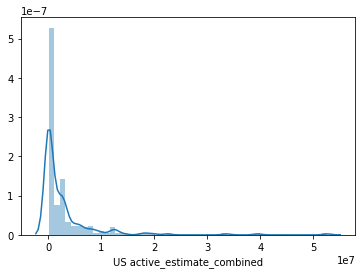

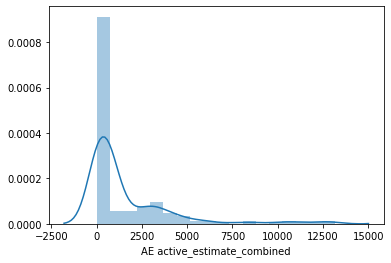

In [22]:
# Can plot selected distributions for debugging
for code in ["US", "AE"]:
  try:
    s = samples[f"{code} active_estimate_combined"]
    seaborn.distplot(s)
    plt.show()
  except KeyError:
    pass

# Countermeasures

This part of the notebook allows you to do scenario modelling using probability distributions, and then automatically turn those scenarios into GLEAMviz definition files [1].

### Basic usage

Scenarios are specified in spreadsheets; where each free parameter can either be specified as a number or as the ID of a Foretold distribution.

[This document](https://docs.google.com/document/d/1CJmoL0ypDTKjtpVLdyVTajeqKRp4HKujEduavkwobl8/edit?usp=sharing) explains how to format the spreadsheet, and [here](https://docs.google.com/spreadsheets/d/1kAboAHnu2KK8p-1adM8L4ngrMfr2EmOsVICwfFKCEPE/edit?usp=sharing) is an example spreadsheet. Any Foretold distribution should be added to [this channel](https://www.foretold.io/c/93c557b5-ac8d-4201-a6d7-7ca2d2574304).

Then use the function: `make_countermeasures_csv(countermeasures_url, countermeasures_sheet)`


---

[1] Note: at the moment this outputs a CSV version of the spreadsheet, [this issue](https://github.com/epidemics/covid/issues/406) tracks when it will be able to automatically generate gleam files.


In [23]:
# Make countermeasures CSV
def make_countermeasures_csv(countermeasures_url, countermeasures_sheet):
  input_data = load_spreadsheet(countermeasures_url, countermeasures_sheet)
  headers = input_data[0]
  value_column = headers.index("Value")
  output_data = []
  num_samples = 100

  quantiles =[0.05 * i for i in range(21)]

  for row in tqdm.notebook.tqdm(input_data[1:]):
    d = {h: v for (h,v) in zip(headers, row)}
    value = row[value_column]
    if is_uuid(value):
      foretold_question = foretold.get_question(value)
      d.update({
          str(round(q,2)): foretold_question.quantile(q) for q in quantiles 
          })
    else:
      d.update({
          str(round(q,2)): value for q in quantiles 
          })
    output_data.append(d)
  countermeasures_df = pd.DataFrame(output_data)
  display(countermeasures_df)

  countermeasures_df.to_csv("countermeasures.csv")
  # If this doesn't work, you can find this file in the files pane at the side of
  # the screen, right click and download
  time.sleep(1)
  try:
    google.colab.files.download("countermeasures.csv")
  except:
    pass

make_countermeasures_csv("https://docs.google.com/spreadsheets/d/1kAboAHnu2KK8p-1adM8L4ngrMfr2EmOsVICwfFKCEPE/edit#gid=0",
                         "Sheet1")

,Region,Value,Start date,"End date (in future might be replaced with Foretold ID, but not in MVP)",Type,Class,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
0,Sao Paulo,46fbf258-70a9-4c39-9f3b-5d6f91930632,2020-03-20,2020-04-20,Countermeasure package,1,1771.06,12312.2,17323.6,21797.8,26159.9,30592.2,35202.9,40102,45374.6,51135.8,57514.7,64699.1,72915.3,82511.7,93996.1,108189,126546,151939,191312,269576,1.86406e+06
1,Sao Paulo,bcba6198-093c-4534-b17a-5815386ac64f,2020-04-20,2020-05-20,Countermeasure package,1,473.057,3724.41,5354.37,6837.89,8302.11,9804.89,11385.9,13079.3,14917.6,16938.9,19196.4,21759.1,24709.5,28184.3,32372.7,37602.3,44427.2,53968.4,68966.3,99354.3,777209
2,Sau Paulo,46fbf258-70a9-4c39-9f3b-5d6f91930632,2020-03-20,2020-04-20,Countermeasure package,2,1771.06,12312.2,17323.6,21797.8,26159.9,30592.2,35202.9,40102,45374.6,51135.8,57514.7,64699.1,72915.3,82511.7,93996.1,108189,126546,151939,191312,269576,1.86406e+06
3,Rio De Janeiro,46fbf258-70a9-4c39-9f3b-5d6f91930632,2020-03-20,2020-04-20,Background condition,1,1771.06,12312.2,17323.6,21797.8,26159.9,30592.2,35202.9,40102,45374.6,51135.8,57514.7,64699.1,72915.3,82511.7,93996.1,108189,126546,151939,191312,269576,1.86406e+06
4,Rio De Janeiro,1.2,2020-04-20,2020-05-20,Background condition,1,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2
5,Rio De Janeiro,46fbf258-70a9-4c39-9f3b-5d6f91930632,2020-03-20,2020-04-20,Background condition,2,1771.06,12312.2,17323.6,21797.8,26159.9,30592.2,35202.9,40102,45374.6,51135.8,57514.7,64699.1,72915.3,82511.7,93996.1,108189,126546,151939,191312,269576,1.86406e+06


## Generate gleam files

In `epimodel.gleam.definition`, there is a class `GleamDefinition` with many methods for manipulating a given definition XML - add seed regions, add exceptions, adjust parameters.

For example of usage, see `generate_simulations`. It generates an entire batch for the website, but the main steps are the same.

One of the steps is to take region estimates (e.g. countries or states) and distribute these down to Gleam "basins" (city-like regions). This is done by our function `algorithms.distribute_down_with_population` in the above.
The modelers need a starting XML - I would let them provide it if they want to modify the disease params etc.